### Table of contents

* [Import packages and define functions](#Import-Packages)
* [Load Data](#Load-Data)
* [Data Preprocessing](#Data-Preprocessing)
* [Modeling and Evaluation](#Modeling-and-Evaluation)

### Import Packages

In [2]:
# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')
import seaborn as sns
# sns.set_style('whitegrid')
from datetime import datetime
import missingno as msno
import matplotlib.ticker as ticker
from scipy import stats
from time import sleep
import teradatasql

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, recall_score, classification_report, accuracy_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
# from imblearn.over_sampling import SMOTE
import itertools
import xgboost as xgb

In [4]:
def fetch_from_td(host, user, password, query):
    '''
    This function establishes connection to the teradata,
    execute the corresponding SQL query
    and returns a pandas dataframe
    
    Input:
    Output: Pandas DataFrame
    '''
    
    tdcon = teradatasql.connect(None, host=host, user='c092329', password='Scot0(*&')
    cursor = tdcon.cursor() # establish the cursor
    
    cursor.execute(query)
    
    df = pd.DataFrame(cursor.fetchall())
    df.columns = [x[0].lower() for x in cursor.description] # grab the column names
    
    return df

In [5]:
def plot_missing(df, show_count = False):
    
    fig, ax = plt.subplots(figsize = (15,8))
    miss = df.apply(lambda x: x.isnull().sum() / len(df)).sort_values(ascending = False)

    # Formatting ax
    ax = sns.barplot(y = miss.values, x = miss.index)
    
    if show_count:
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.2%'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 10), 
                        textcoords = 'offset points')
    else:
        pass

    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    ax.set_ylim(0,1)  
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
    ax.set_ylabel('Percentage of Missing')

    # formatting ax2
    ax2 = ax.twinx()
    ax2.set_ylim(0, len(df))
    ax2.set_ylabel('Count of Missing')

    # Use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(10000))
    ax2.set_yticklabels(['{:,.0f}K'.format(x/1000) for x in ax2.get_yticks()])

    plt.title('Missing Value')
    fig.tight_layout()
    sns.despine()
    plt.show()

In [6]:
def plot_unique(df, col, show_count = False, show_percent = False, fontsize = 15, figsize = (15,8), hue = None): 
    
    fig, ax = plt.subplots(figsize = figsize)
    
    ax = sns.countplot(x = col, hue = hue, data = df)
    
    # show exact number on each bar
    if show_count:
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 10), 
                        textcoords = 'offset points')
    else:
        pass
    
    # show percentages on each bar
    if show_percent:
        bars = ax.patches
        half = int(len(bars)/2)
        left_bars = bars[:half]
        right_bars = bars[half:]

        for left, right in zip(left_bars, right_bars):
            height_l = left.get_height()
            height_r = right.get_height()
            total = height_l + height_r

            ax.text(left.get_x() + left.get_width()/2., height_l + 200, '{0:.0%}'.format(height_l/total), ha="center")
            ax.text(right.get_x() + right.get_width()/2., height_r + 200, '{0:.0%}'.format(height_r/total), ha="center")
    else:
        pass

    ax.set_title('{} Count distribution'.format(col), fontsize = fontsize)
    
    if hue != None:
         plt.legend(loc = 'upper right', frameon = False)
    else:
        pass
    
    fig.tight_layout()
    sns.despine()
    plt.show()

In [7]:
def plot_distribution(df, col, target, figsize = (15,8)):
    
    fig, axes = plt.subplots(nrows = 2, figsize = figsize)
    
    for _ in sorted(df[target].unique().tolist()):
        sns.distplot(df[df[target] == _][col], hist = True, rug = False, label = _)
    
    ax = sns.boxplot(x = target, y = col, data = df, ax = axes[0])
    
    plt.legend(loc = 'upper right', frameon = False)
    ax.set_title('distribution of {} by response group'.format(col))
    
    fig.tight_layout()
    sns.despine(left = True)
    plt.show()

In [8]:
def plot_time(df, col):
    plt.figure(figsize = (15,8))
    df[col].value_counts().sort_index().plot()
    plt.title(str(col) + ' Count')
    sns.despine()
    plt.show()

In [9]:
def plot_corr(df, figsize):
    '''
    This function plots the correlation plot between numeric variables
    
    '''
    corr = df.select_dtypes('float64').corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype = np.bool)
    
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize = figsize)
    
    # Generate a custome diverging colormap
    cmap = sns.diverging_palette(220, 10 , as_cmap = True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, vmin = -1, center = 0,
               square = True, linewidths = 0.5, cbar_kws = {'shrink':0.5})
    
    plt.title('Correlation Plot of Numeric Variables')
    
    sns.despine()
    plt.tight_layout()
    plt.show()

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3f}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

In [11]:
def plot_roc(X_test, y_test, algo):
    '''
    This function plots the ROC curve for an algorithm
    
    '''
    probs = algo.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [12]:
def plot_confusion(thresh, algo):
    ''' 
    This function plot the confusion matrix
    
    '''
    probs = algo.predict_proba(X_test)
    y_pred = [1 if x > thresh else 0 for x in probs[:,1]]
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, ['0', '1'], )
    pr, tpr, fpr = show_data(cm, print_res = 1)

In [13]:
def plot_importance(X, algo, num_feature_show):
    '''
    This function plot the feature importance for random forest algorithm
    
    '''
    
    impor = pd.DataFrame({
        'feature': X.columns,
        'importance': algo.feature_importances_
    })
    
    impor = impor.sort_values('importance', ascending = False)
    
    fig, axes = plt.subplots(figsize = (15,8))
    sns.barplot(y = 'feature', x = 'importance', data = impor.iloc[:num_feature_show,:])
    
    # plt.xticks(rotation = 90)
    plt.title('Feature Importance')
    
    sns.despine()
    plt.tight_layout()
    plt.show()

### Load Data

In [15]:
df.head()

,od_ordr_dtl_gid,eph_link_id,od_ptnt_id,od_rx_nbr,od_shpmt_dt,od_exhst_dt,min_start_dt,max_start_dt,refill_ind_final,spclt_drug_cls_nm,...,inc_hh_med_prscbr,eng_poor_prscbr,spanish_prscbr,in_hh_mean_prscbr,poverty_prscbr,asian_prscbr,black_prscbr,nat_am_prscbr,refill_early,region
0,142644533,12221469001,2720337,15007899,2019-01-31,2019-02-28,2019-02-22,2019-02-24,1,MULTIPLE SCLEROSIS,...,44075.07,0.46349,0.91246,3.43,0.28976,0.00976,0.01045,0.00101,1,SOUTH
1,128336348,12329406093,2801116,15673100,2018-10-17,2018-11-16,2018-11-13,2018-11-13,1,ONCOLOGY,...,27880.69,0.03613,0.05327,2.45,0.29143,0.00959,0.25779,0.01489,1,SOUTH
2,156623510,12023193668,1827370,17377957,2019-05-15,2019-06-14,2019-06-10,2019-06-12,1,ONCOLOGY,...,43931.78,0.10036,0.11454,2.15,0.15539,0.04176,0.20926,0.00103,1,SOUTH
3,127383514,12028079717,1067931,16393383,2018-10-10,2018-11-09,2018-11-07,2018-11-07,1,ONCOLOGY,...,30000.00,0.04864,0.20570,2.45,0.23422,0.00281,0.52468,0.01232,1,NORTHEAST
4,135671511,12368095952,4293756,4699422,2018-12-10,2019-01-09,2019-01-05,2019-01-12,1,ONCOLOGY,...,35391.05,0.30938,0.38869,2.40,0.24870,0.07126,0.14691,0.00505,1,WEST


In [16]:
df.shape

(61918, 80)

#### Target Variable

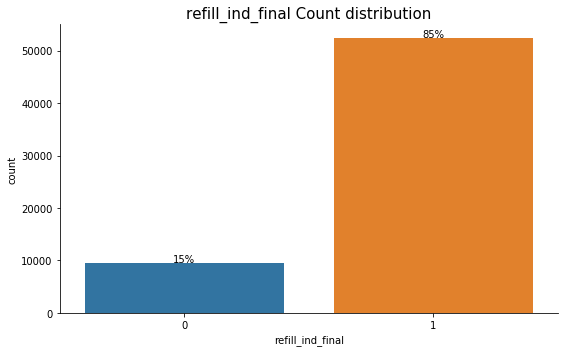

In [17]:
plot_unique(df, 'refill_ind_final', show_percent = True, figsize = (8,5))

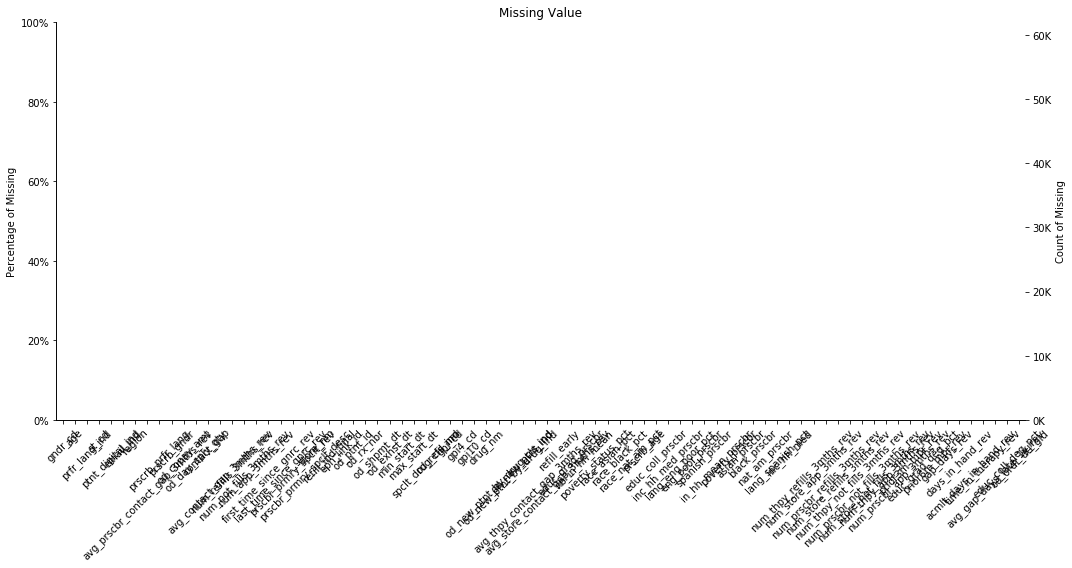

In [18]:
plot_missing(df)

### Data Preprocessing

In [25]:
col_names = df.columns.tolist()
id_col = col_names[:4]
date_col = col_names[4:8]
target = col_names[8]
categorical = col_names[9:28] + ['region', 'refill_early']
numeric = col_names[28:]

In [26]:
for _ in ['region', 'refill_early']:
        numeric.remove(_)

In [27]:
df[numeric] = df[numeric].astype('float64')
df[categorical] = df[categorical].astype('object')

#### Categorical Variables

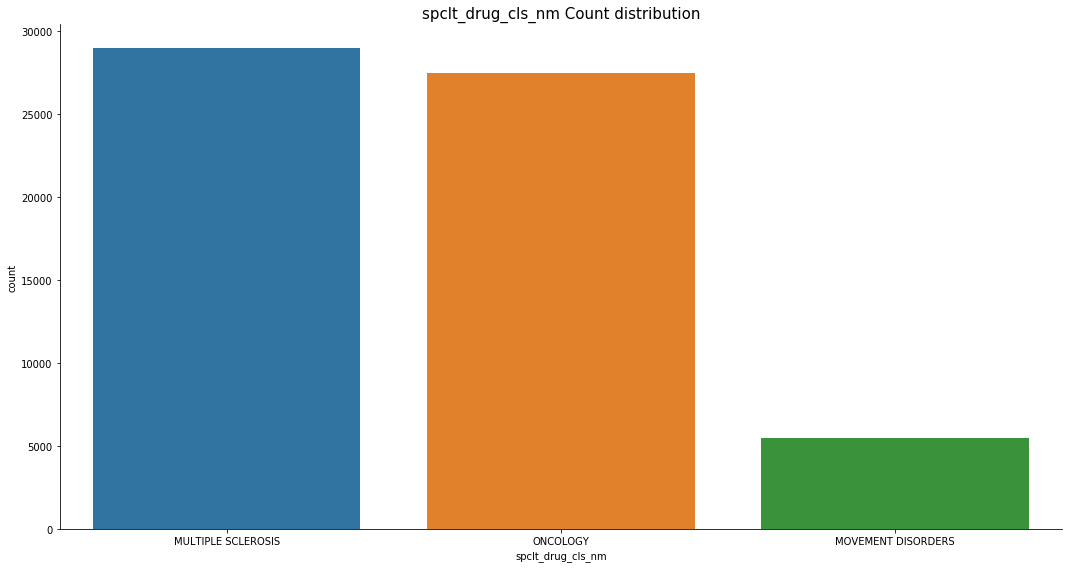

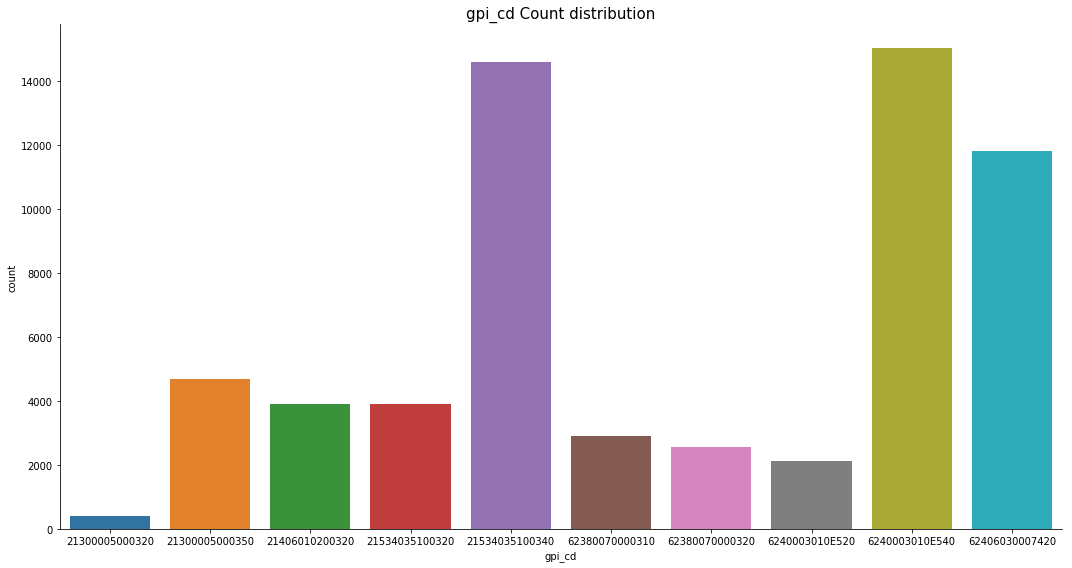

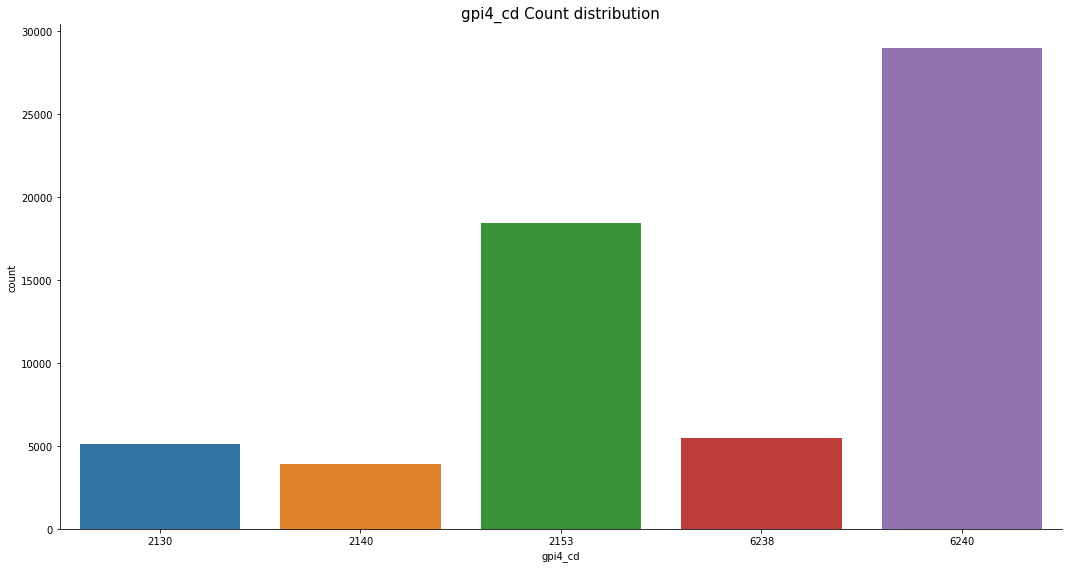

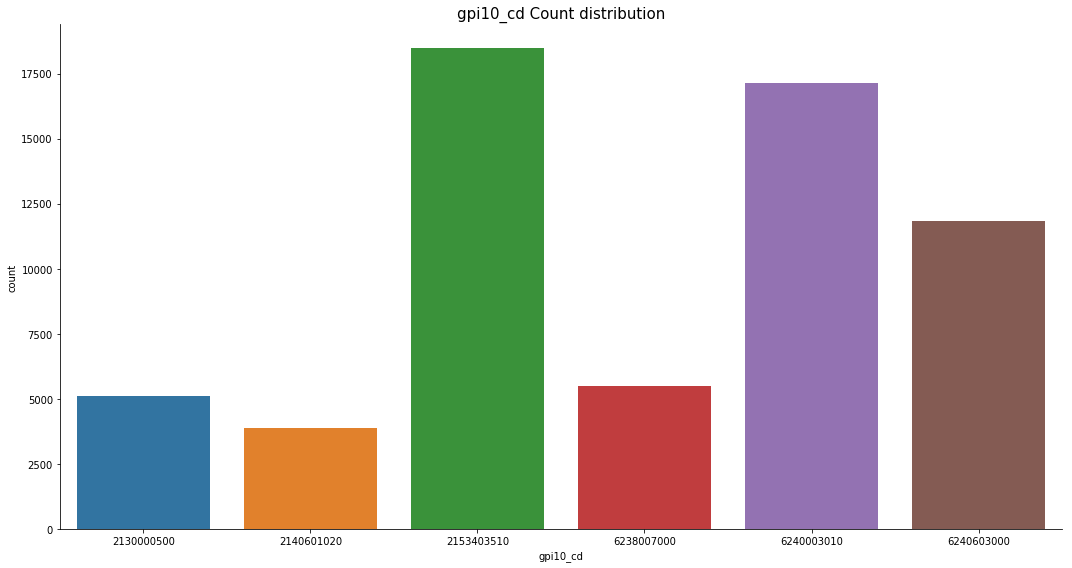

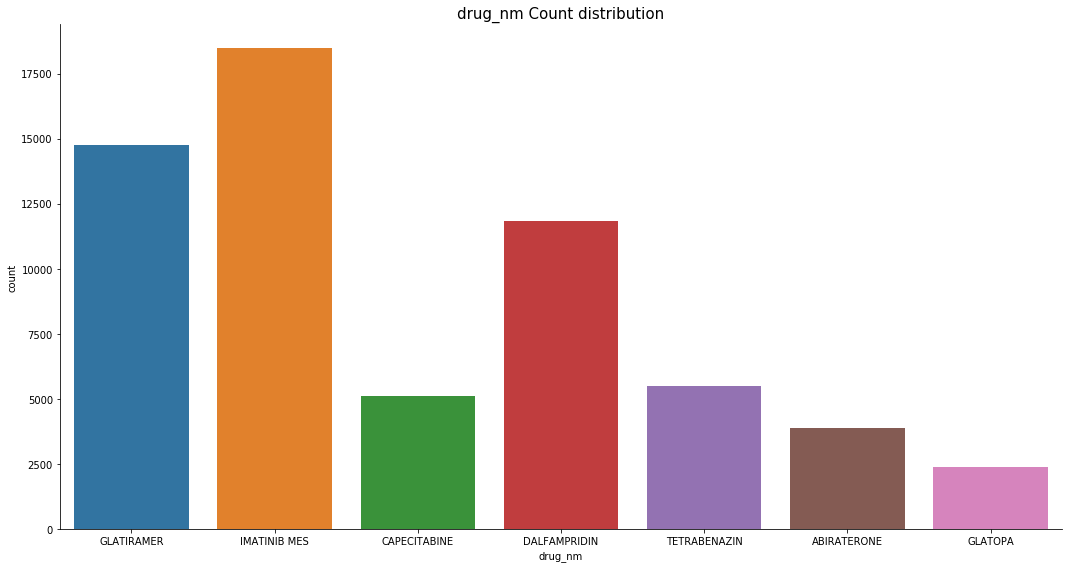

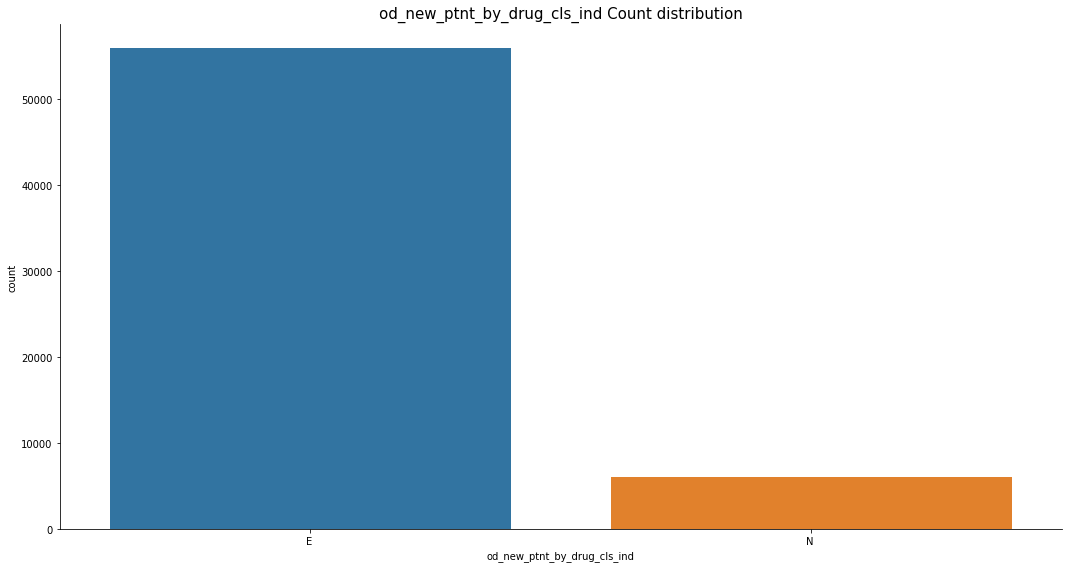

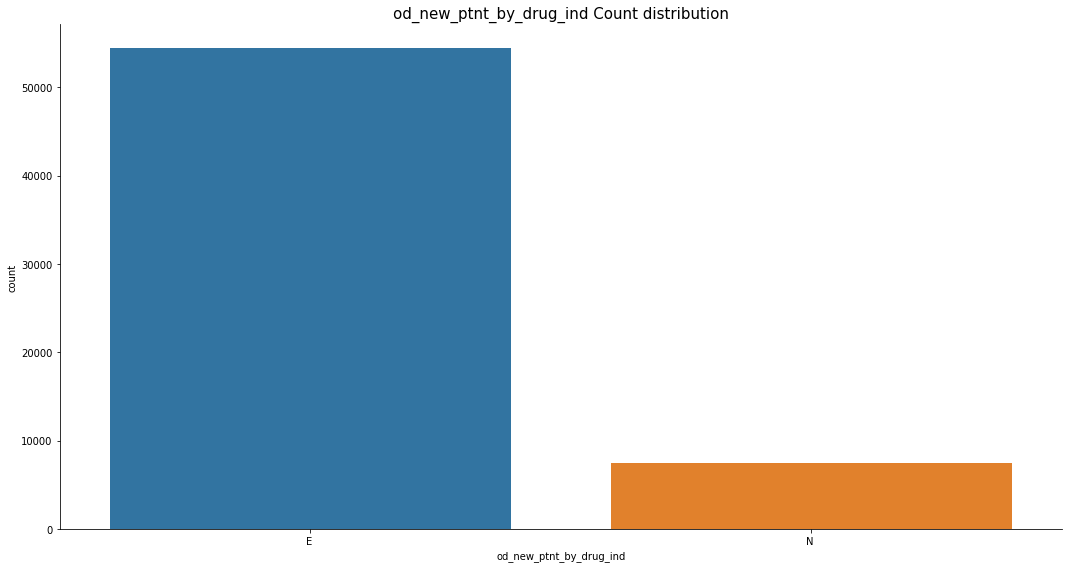

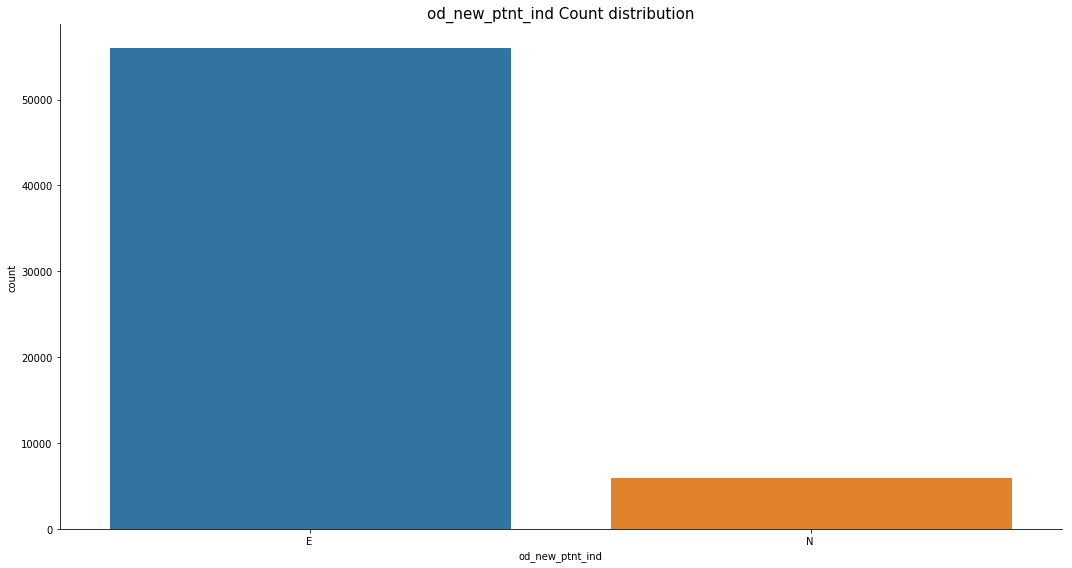

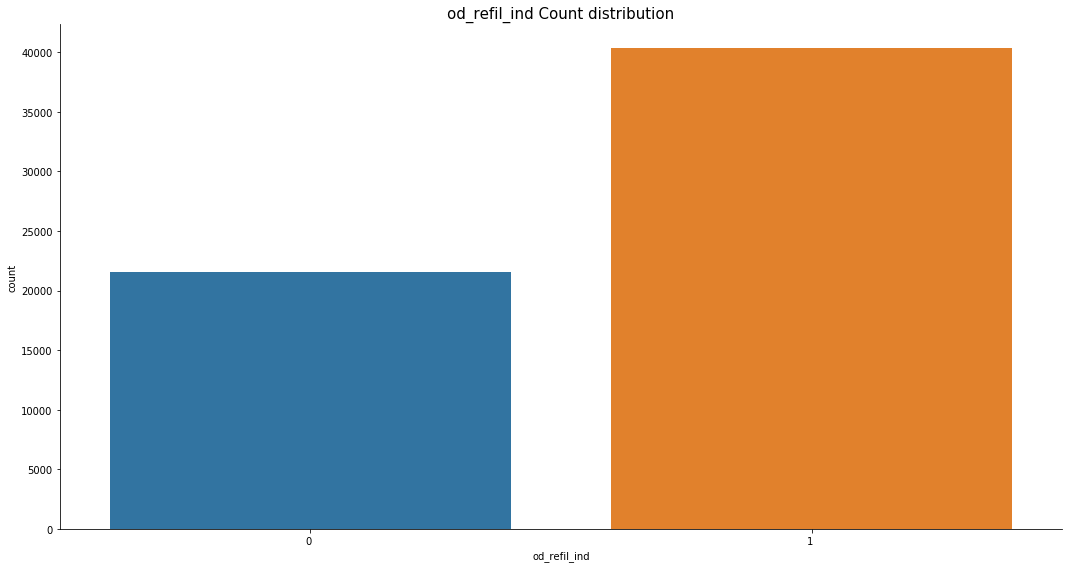

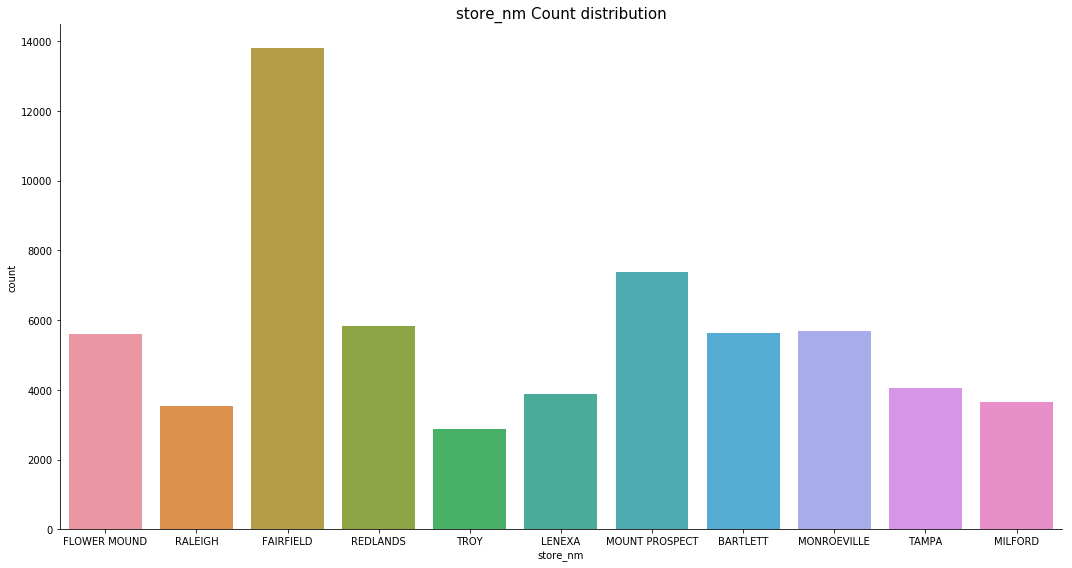

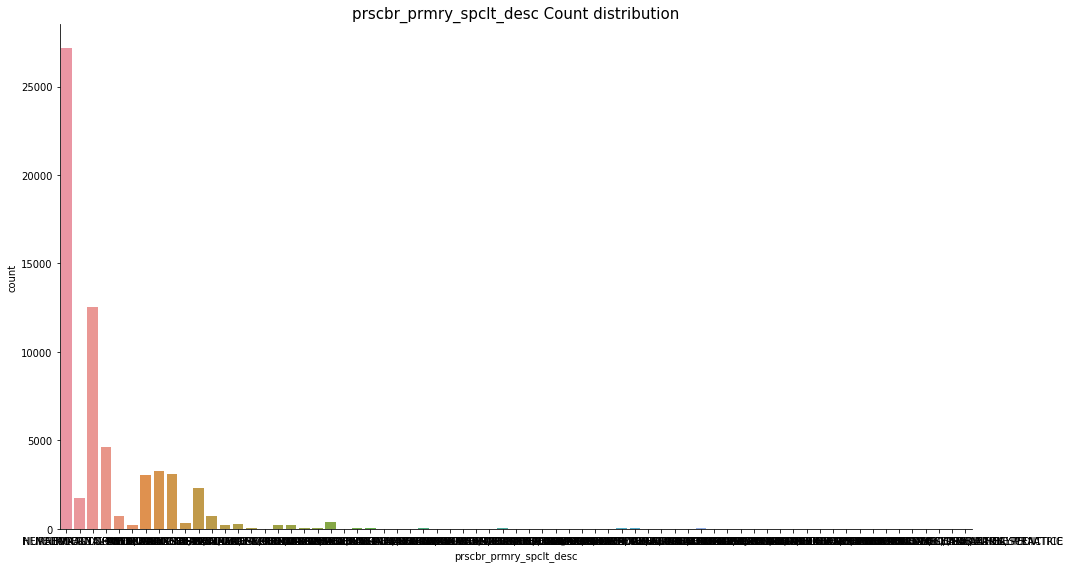

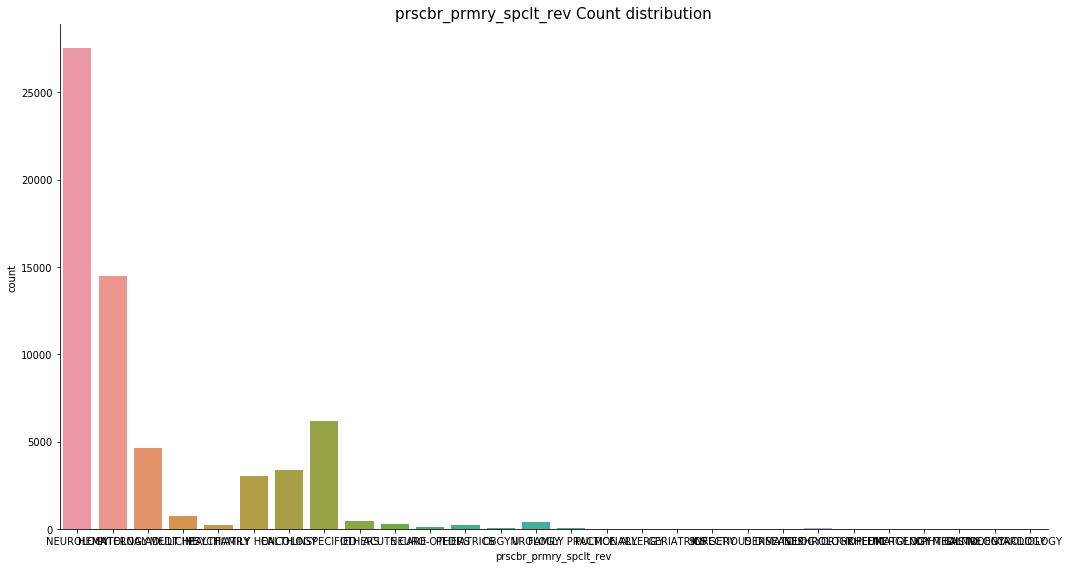

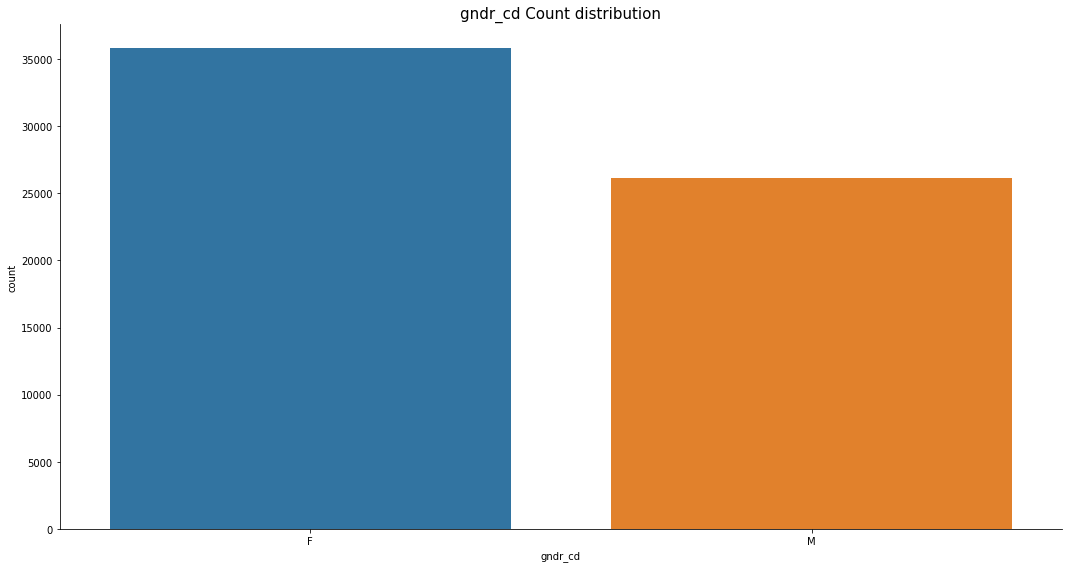

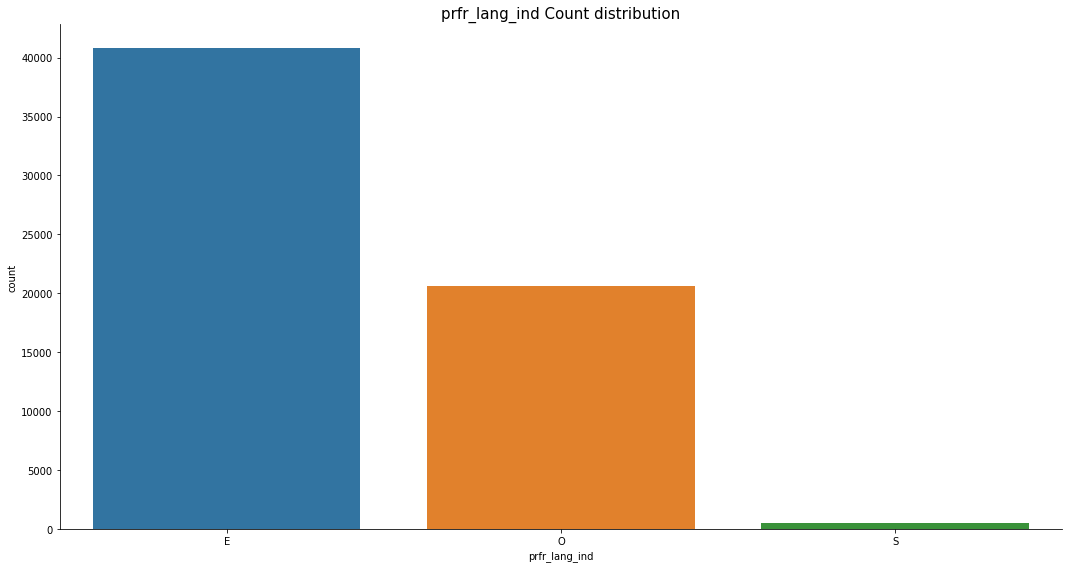

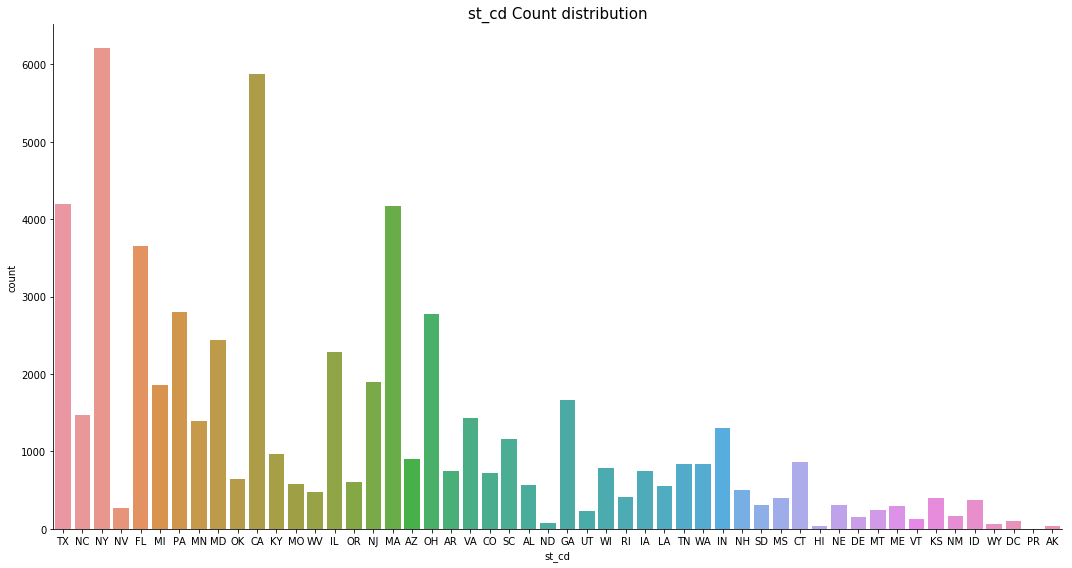

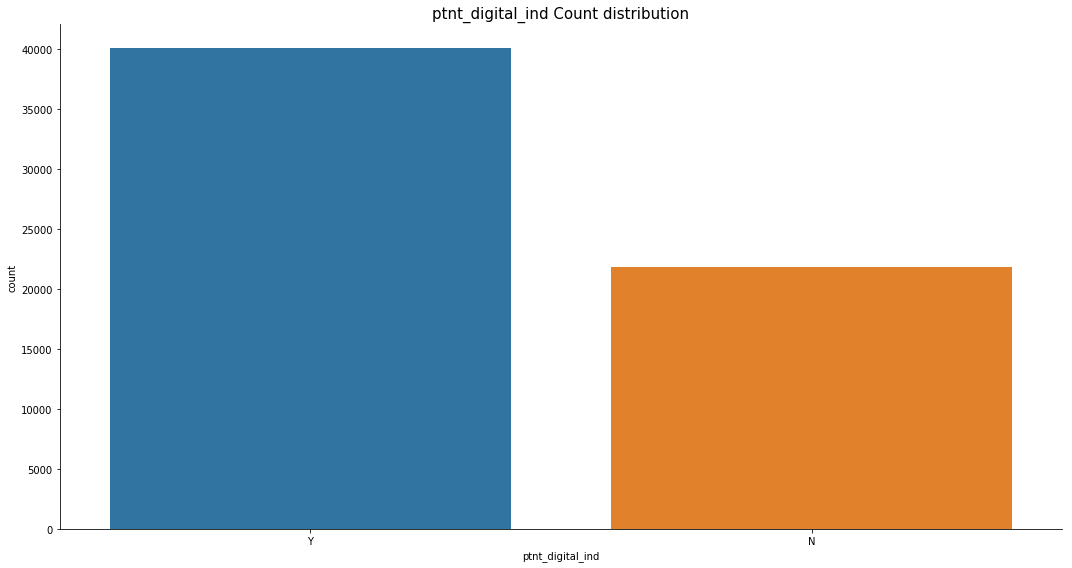

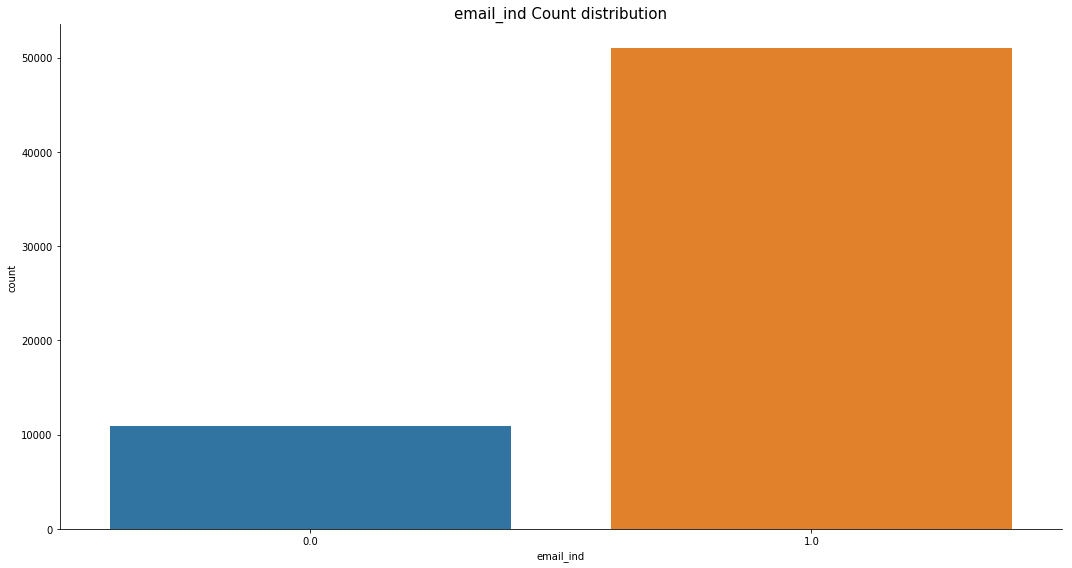

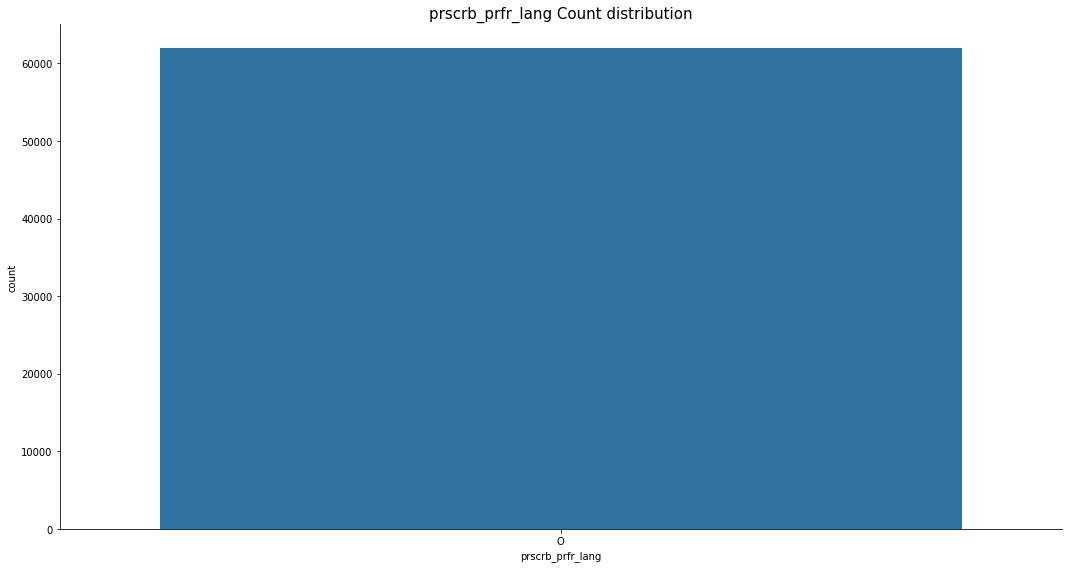

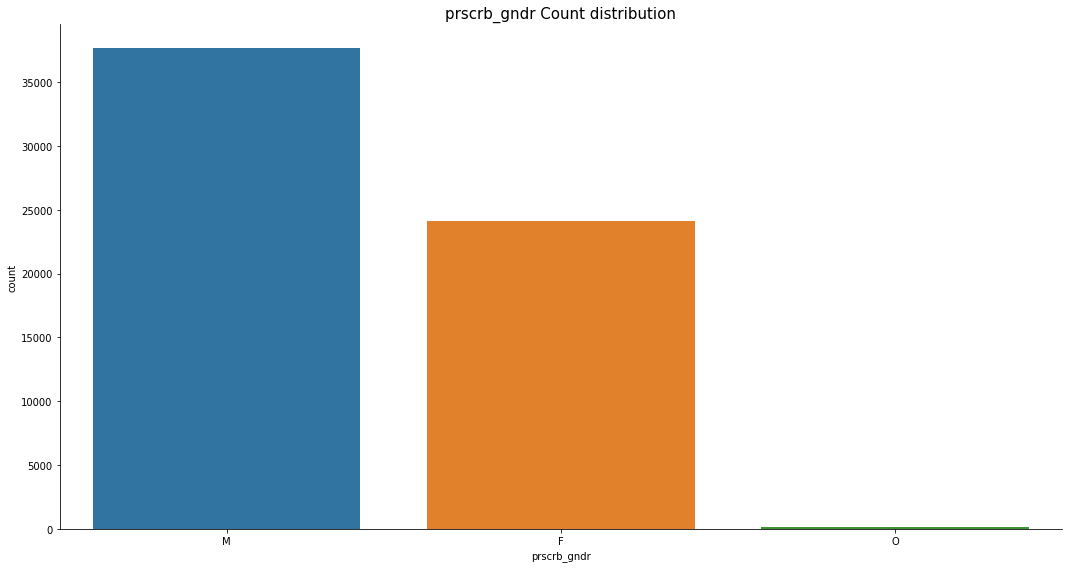

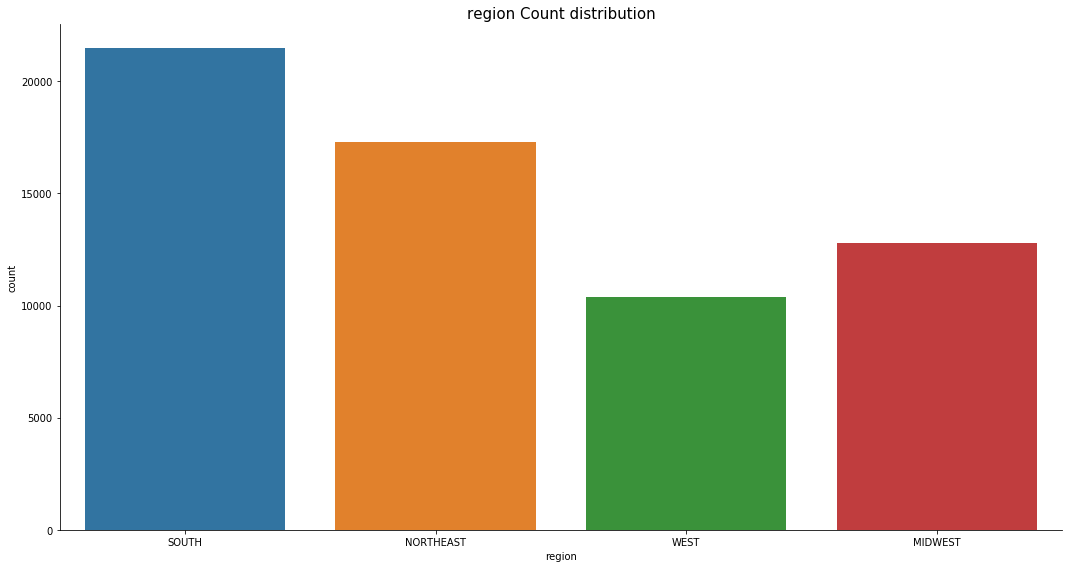

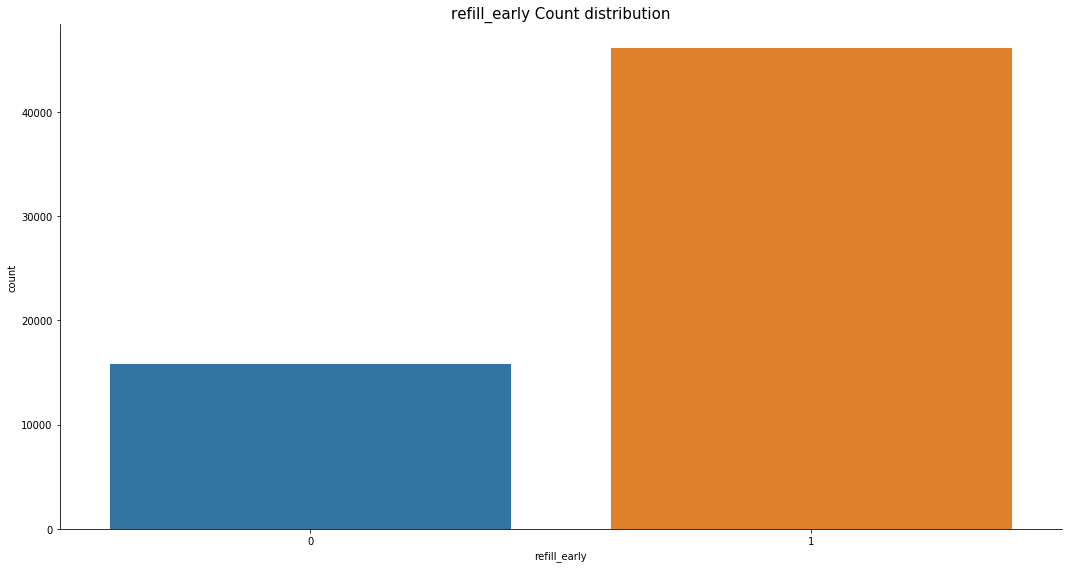

In [28]:
for _ in categorical:
    plot_unique(df, col = _)

#### Numeric Variables

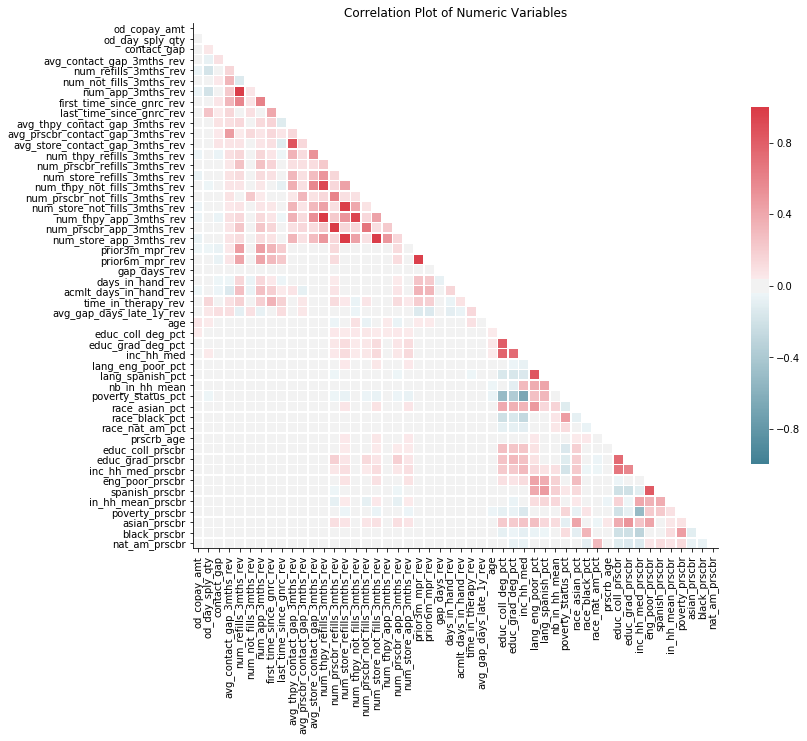

In [29]:
plot_corr(df, figsize = (12,12))

In [38]:
def preprocessing(df, scale = False, OneHotEncoder = False):
    
    # Drop date, id, and columns with too many groups
    cols_to_exclude = ['st_cd', 'prscbr_prmry_spclt_desc', 'prscrb_age','prscrb_prfr_lang', 'refill_early', 
                       'contact_gap', 'prscbr_prmry_spclt_desc']
    
    temp_df = df.drop(cols_to_exclude + id_col + date_col, axis = 1)
    
    # add age_group category 1 - 48, 49 - 58, 59 - 65, 66 - 99, labeled as 1,2,3,4 respectively
    df['age_group'] = pd.qcut(df['age'], 4, labels = [1,2,3,4])
    temp_df = temp_df.drop('age', axis = 1)
    
    # standardization
    if scale:
        col = temp_df.select_dtypes('float64').columns
        sc = StandardScaler()
        temp_df[col] = sc.fit_transform(temp_df[col])
        
    # dummy coding
    if OneHotEncoder:
        cat_col = temp_df.select_dtypes('object').columns.tolist()
        dummy_df = pd.get_dummies(temp_df[cat_col])
        temp_df = pd.concat([temp_df, dummy_df], axis = 1)
        temp_df = temp_df.drop(cat_col, axis = 1)

    return temp_df

In [72]:
df_scale = preprocessing(df, scale = True, OneHotEncoder = True)
df_no_scale = preprocessing(df, scale = False, OneHotEncoder = True)

### Modeling and Evaluation

In [32]:
X_scale = df_scale.drop('refill_ind_final', axis = 1)
y_scale = df_scale['refill_ind_final']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scale,
                                                   y_scale,
                                                   test_size = 0.2,
                                                   random_state = 123)

#### Logistic Regression

In [141]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

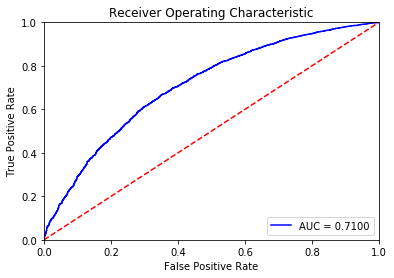

In [142]:
plot_roc(X_test, y_test, algo = lr)

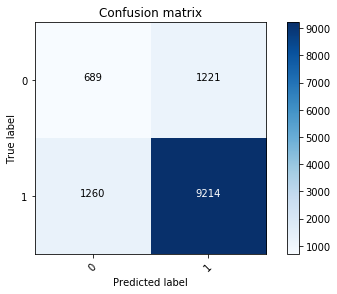

Precision =     0.883
Recall (TPR) =  0.880
Fallout (FPR) = 0.639


In [143]:
plot_confusion(thresh = 0.75, algo = lr)

#### Random Forest

In [144]:
rf = RandomForestClassifier(n_estimators = 100,
                            max_features = 3,
                            max_depth = 3,
                            criterion = 'gini',
                            random_state = 321,
                           oob_score = True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

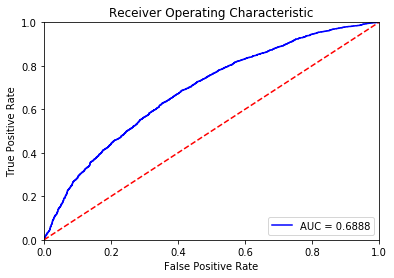

In [145]:
plot_roc(X_test, y_test, algo = rf)

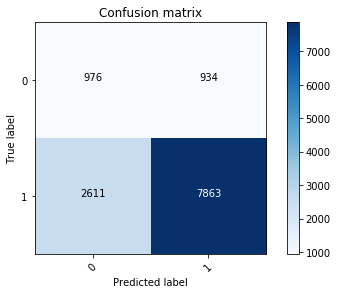

Precision =     0.894
Recall (TPR) =  0.751
Fallout (FPR) = 0.489


In [146]:
plot_confusion(thresh = 0.84, algo = rf)

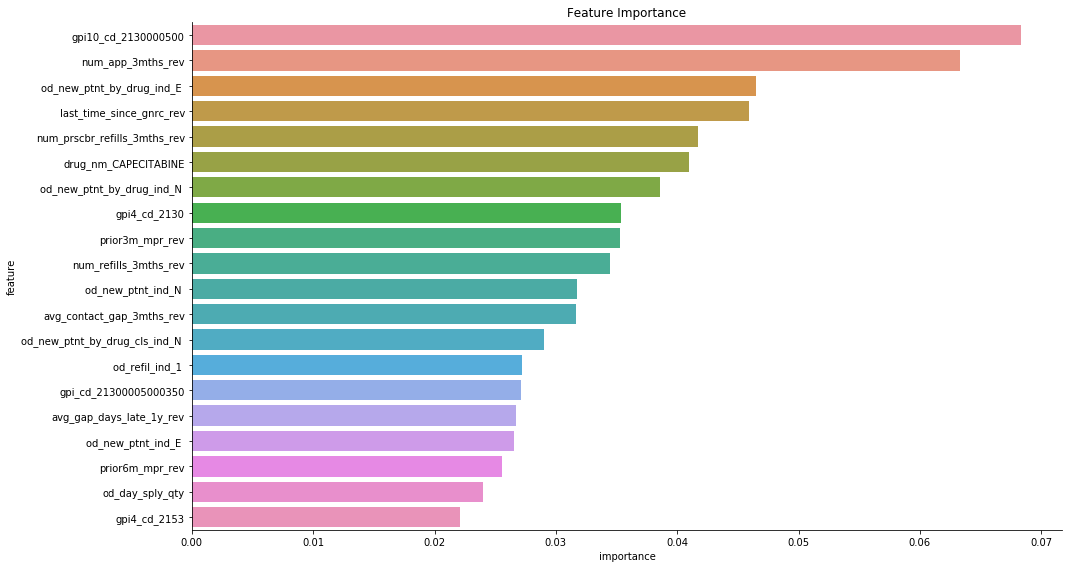

In [149]:
plot_importance(X_scale, rf, num_feature_show = 20)

#### Xgboost

In [82]:
data_dmatrix = xgb.DMatrix(data = X_scale, label = y_scale)

In [150]:
xgb_clf = xgb.XGBClassifier()

In [151]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [152]:
y_pred = xgb_clf.predict(X_test)

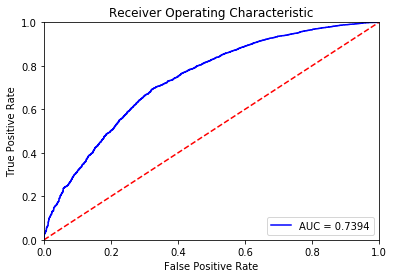

In [153]:
plot_roc(X_test, y_test, algo = xgb_clf)

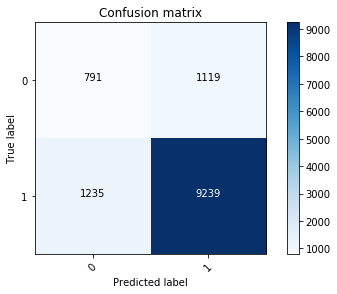

Precision =     0.892
Recall (TPR) =  0.882
Fallout (FPR) = 0.586


In [154]:
plot_confusion(thresh = 0.75, algo = xgb_clf)

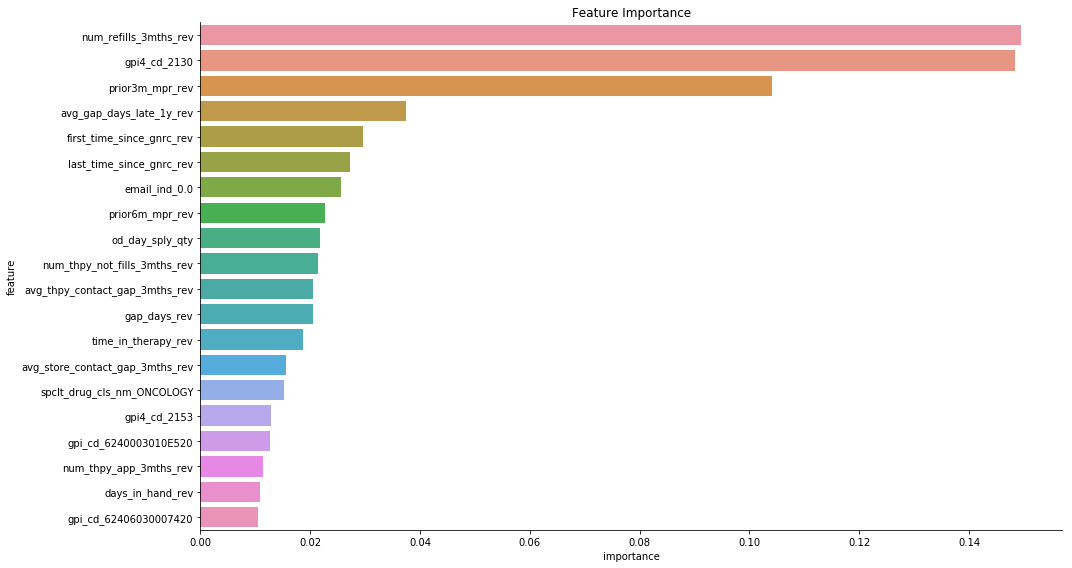

In [157]:
plot_importance(X_train, xgb_clf, 20)

In [43]:
# tdcon.close() # close the connection

#### Tuning Xgboost

#### General Parameters
| Parameter Name | Definition | Default | Typical Values |
| --- | --- | --- | --- |
| `booster` | type of model to run at each iteration, tree-based model and linear model | None | 'gbtree', 'gblinear' |
| `silent` | default prints running messages | 0 | 0, 1|
| `nthread` | used for parallel processing and number of cores in the system shall be entered | maximum cores available | user-specific

#### Booster Parameters
| Parameter Name | Definition | Default | Typical Values |
| --- | --- | --- | --- |
| `eta` | learning rate, makes the model more robust by shrinking the weights at each step | 0.3 | 0.01 - 0.2 |
| `min_child_weight` | Define the minimum sum of weights of all obs in a child. Used to control overfitting. Higher value prevents model from learning relations which might be highly specific to particular sample selected for a tree | 1 | cv-tuned |
|`max_depth`| Maximum depth of a tree, used to control over-fitting as higher value will allow model to learn relations very specific to chosen sample | 6 | 3 - 10, cv-tuned
|`max_leaf_nodes`| Maximum number of terminal nodes or leaves in a tree, can be defined in place of `max_depth` | None | None |
|`gamma`| Specifies the mininum loss reduction requred to make a split. A node is split only when positive reduction in loss can be achieved | 0 | cv-tuned
|`subsample`| Defines the fraction of obs to be used for each tree. Lower values lead to conservative learning | 1 | 0.5 - 1 |
|`colsample_bytree`| Defines the fraction of features to be used for each tree | 1 | 0.5 - 1 |
|`lambda`| L2 regularization term on weights. Used to handle regularization in XGBoost | 1 | cv-tuned |
|`alpha`| L1 regularization term on weights. Can be used in high-dimensionality so algorithm runs faster | 0 | cv-tuned |
|`scale_pos_weight`| A value greater than 0 should be used in case of high-class imbalance as it helps in faster convergence | 1 | None |

#### Learning Parameters
* These paramters are used to define the optimization objetive the metric to be calculated at each step

| Parameter Name | Definition | Default | Typical Values |
| --- | --- | --- | --- |
| `objective` | Defines the loss function to be minimized | `binary:logistic`, logistic regression for binary classification, returns predicted probability |
|$\space$|$\space$|`multi:softmax`, multiclass classifcation using the softmax objective, return predicted class, `num_class` needs to be set|
|$\space$|$\space$|`multi:softprob`, same as softmax, but returns predicted probability of each data point||
|`eval_metric`| metric used to evaluate performance | `rmse`, `mae`, `logloss`, `error`, `merror`, `mlogloss`, `auc` ||
|`seed`| Random number seed, used for reproductivity | `123`||

* Xgboost module has sklearn wrapper called XGBClassifier which used sklearn naming convension
* `eta` -> `learning_rate`
* `lambda` -> `reg_lambda`
* `alpha` -> `reg_alpha`

* In Xgboost, `n_estimator` is defined as the `num_boosting_rounds` while calling the fit function in the standard implementation.

In [158]:
def model_fit(alg, X_train, y_train, X_test, y_test, useTrainCV = True, cv_folds = 5, early_stopping_rounds = 50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(data = X_train, label = y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, 
                          num_boost_round = alg.get_params()['n_estimators'], 
                          nfold = cv_folds, metrics = 'auc', 
                          early_stopping_rounds = early_stopping_rounds)
        
        print(cvresult)
        alg.set_params(n_estimators = cvresult.shape[0])
        
    # Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric = 'auc')
    
    # Predict training set
    plot_roc(X_test, y_test, algo = alg)

#### General approach to parameter tuning
* Choose a relatively high learning rate. Generally 0.1 but any number between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGB has a function called `cv` which performs cross-validation at eah boosting iteration and returns the optimum number of trees required
* Tune tree-specific parameters (`max_depth`, `min_child_weight`, `gamma`, `subsample`, `colsample_bytree`) for decided learning rate and number of trees. 
* Tune regularization parameters to reduce model complexity and enhance performance
* Lower the learning rate and decide optimal parameters

#### Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

1. `max_depth` = 5: This should be between 3 - 10
2. `min_child_weight` = 1: A smaller value is chosen because highly imbalanced class problem and leave node can have small sizes
3. `gamma` = 0, A smaller value like 0.1 - 0.2 can be used, which will be tuned later
4. `subsample, colsample_bytree` = 0.8
5. `scale_pos_weight` = 1, because highly imbalance

In [159]:
xgb1 = xgb.XGBClassifier(
 learning_rate = 0.2, # 
 n_estimators = 1000, # number of weak learners/estimators/iterations needed
 max_depth = 5, # max_depth of each tree
 min_child_weight = 1, # minimum sum of weights of all tree nodes
 gamma = 0, # minimum reduction in loss used to build 
 subsample = 0.8, # proportion of obs used to build each tree
 colsample_bytree = 0.8, # proportion of features used to build each tree
 objective = 'binary:logistic', # for classification
 # nthread = 4, 
 scale_pos_weight = 1, # used for imbalance
 seed = 27)

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.696462       0.002088       0.686587      0.008839
1         0.721646       0.007057       0.711733      0.009443
2         0.732614       0.001715       0.720018      0.007138
3         0.735670       0.002523       0.722891      0.007406
4         0.738325       0.002853       0.723626      0.007828
5         0.741878       0.003621       0.726014      0.006956
6         0.745730       0.002194       0.728140      0.005694
7         0.748497       0.002422       0.729143      0.006102
8         0.750838       0.002407       0.730165      0.005976
9         0.753761       0.002350       0.730805      0.006640
10        0.756148       0.001911       0.732362      0.007060
11        0.758645       0.001411       0.732658      0.007291
12        0.760900       0.001306       0.732734      0.007296
13        0.763335       0.001279       0.733906      0.006958
14        0.765871       0.001420       0.734298      0

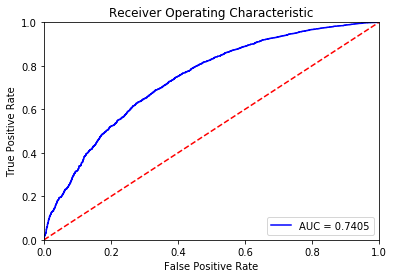

In [160]:
model_fit(xgb1, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)

* As we can see that we got 39 estimators as the optimal `n_estimators` for `learning_rate` of 0.2.

#### Step 2: Tune `max_depth` and `min_child_weight`

In [163]:
param_grid = {
    'max_depth': range(3,10,2),
    'min_child_weight': range(1, 6, 2)
}

gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_grid, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5)
gsearch1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.2, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=39, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [164]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'max_depth': 5, 'min_child_weight': 5}
0.7393002911916313


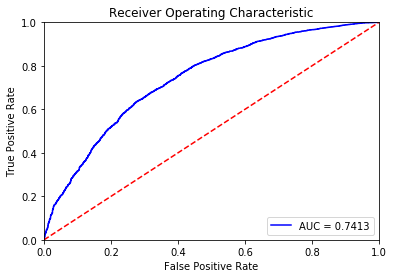

In [173]:
plot_roc(X_test, y_test, algo = gsearch1.best_estimator_)

* 12 combinations give us 5 for `max_depth` and 5 for `min_child_weight` are the best values.

#### Step 3 : Further tune `max_depth` and `min_child_weight`

In [174]:
param_grid = {
    'max_depth': [4,5,6],
    'min_child_weight': [4,5,6]
}

gsearch2 = GridSearchCV(estimator = xgb1, param_grid = param_grid, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5)
gsearch2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.2, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=39, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [177]:
print(gsearch2.best_params_)
print(gsearch2.best_score_)

{'max_depth': 4, 'min_child_weight': 5}
0.7401046343130039


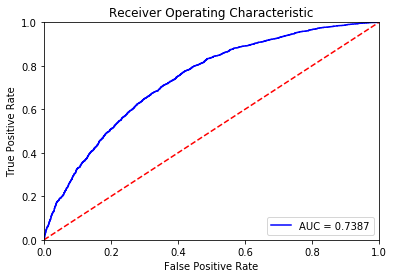

In [176]:
plot_roc(X_test, y_test, algo = gsearch2.best_estimator_)

#### Step 3: Tune `min_child_weight`

In [182]:
# set optimal `max_depth` parameter for xgb1
xgb1.set_params(max_depth = 4)

param_grid = {
    'min_child_weight': range(6,14,2)
}

gsearch3 = GridSearchCV(estimator = xgb1, param_grid = param_grid, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5)
gsearch3.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.2, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=39, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_child_weight': range(6, 14, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [183]:
print(gsearch3.best_params_)
print(gsearch3.best_score_)

{'min_child_weight': 6}
0.740084780121997


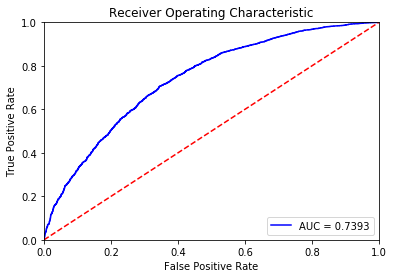

In [184]:
plot_roc(X_test, y_test, algo = gsearch3.best_estimator_)

#### Step 4: Tune `Gamma`

In [187]:
param_grid = {
    'gamma': [i/10.0 for i in range(0,5)]
}

gsearch4 =  GridSearchCV(estimator = gsearch3.best_estimator_, param_grid = param_grid, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5)
gsearch4.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.2, max_delta_step=0, max_depth=4,
       min_child_weight=6, missing=None, n_estimators=39, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [188]:
print(gsearch4.best_params_)
print(gsearch4.best_score_)

{'gamma': 0.2}
0.7400910267348318


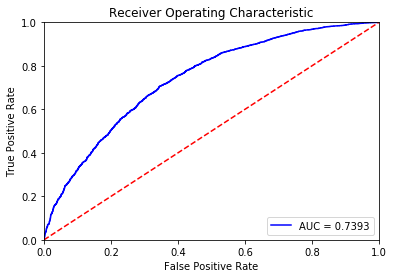

In [189]:
plot_roc(X_test, y_test, algo = gsearch4.best_estimator_)

#### Step 5: Recalibrate number of boosting trees for tuned parameters

In [190]:
xgb2 = gsearch4.best_estimator_

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.685482       0.001786       0.680087      0.007496
1         0.709475       0.007199       0.703856      0.008189
2         0.722842       0.002687       0.715160      0.007049
3         0.727408       0.002806       0.718806      0.006587
4         0.729019       0.003542       0.721000      0.006569
5         0.731371       0.004286       0.722524      0.006490
6         0.734616       0.002514       0.724689      0.005466
7         0.736410       0.002220       0.726020      0.004918
8         0.738389       0.002639       0.727362      0.004668
9         0.740078       0.002204       0.727903      0.005098
10        0.741838       0.002000       0.729198      0.005219
11        0.743537       0.001907       0.729990      0.005119
12        0.744985       0.001793       0.730469      0.005427
13        0.746222       0.001438       0.731063      0.005662
14        0.747815       0.001288       0.731778      0

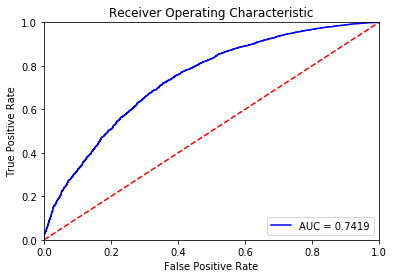

In [192]:
xgb2.set_params(n_estimators = 1000)
model_fit(xgb2, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)

#### Step 6: Tune `subsample` and `colsample_bytree`

In [193]:
xgb2.set_params(n_estimators = 59)

param_grid = {
    'subsample': [i/10.0 for i in range(6,10)],
    'colsample_bytree': [i/10.0 for i in range(6,10)]
}

In [195]:
gsearch5 =  GridSearchCV(estimator = xgb2, param_grid = param_grid, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5)
gsearch5.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.2,
       learning_rate=0.2, max_delta_step=0, max_depth=4,
       min_child_weight=6, missing=None, n_estimators=59, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [196]:
print(gsearch5.best_params_)
print(gsearch5.best_score_)

{'colsample_bytree': 0.8, 'subsample': 0.9}
0.7419785289904104


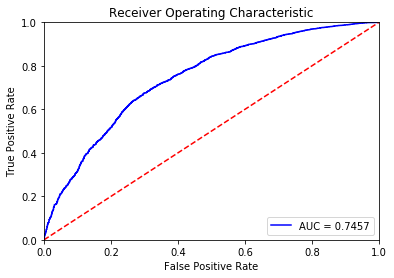

In [197]:
plot_roc(X_test, y_test, algo = gsearch5.best_estimator_)

#### Step 7: Reduce learning rate and increase n_estimators

In [199]:
xgb3 = gsearch5.best_estimator_
xgb3.set_params(learning_rate = 0.05, n_estimators = 5000)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.2,
       learning_rate=0.05, max_delta_step=0, max_depth=4,
       min_child_weight=6, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.9, verbosity=1)

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.685299       0.001637       0.680690      0.004219
1          0.706759       0.006185       0.701338      0.006839
2          0.713303       0.004370       0.707638      0.005257
3          0.715242       0.005403       0.709551      0.002273
4          0.718677       0.003416       0.712916      0.003071
5          0.719262       0.003671       0.713666      0.004024
6          0.721580       0.003302       0.715578      0.004397
7          0.722412       0.002556       0.716953      0.005682
8          0.723451       0.002356       0.717945      0.006121
9          0.723615       0.001925       0.717852      0.006595
10         0.724862       0.001836       0.718514      0.006681
11         0.725836       0.002006       0.719350      0.006573
12         0.726866       0.001426       0.720011      0.006484
13         0.727056       0.001877       0.719959      0.006424
14         0.727926       0.002120      

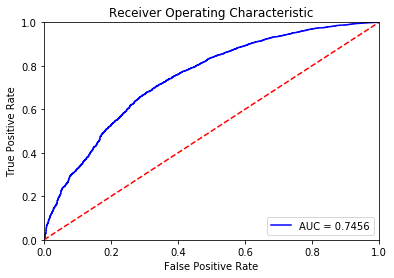

In [200]:
model_fit(xgb3, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)

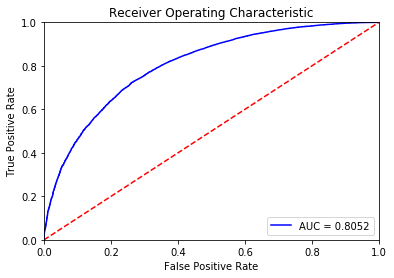

In [262]:
# Test ROC
plot_roc(X_train, y_train, algo = xgb3)

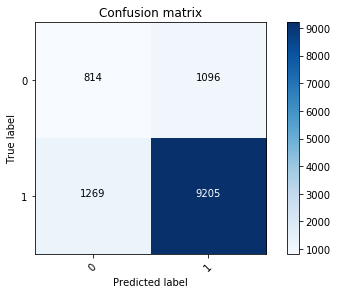

Precision =     0.894
Recall (TPR) =  0.879
Fallout (FPR) = 0.574


In [204]:
plot_confusion(thresh = 0.75, algo = xgb3)

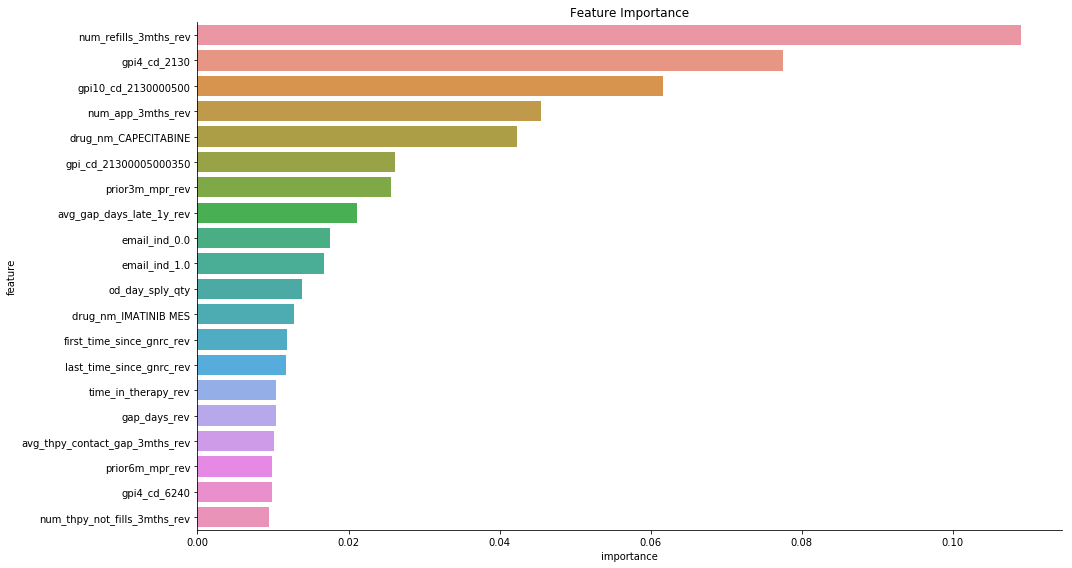

In [205]:
plot_importance(X_train, xgb3, 20)

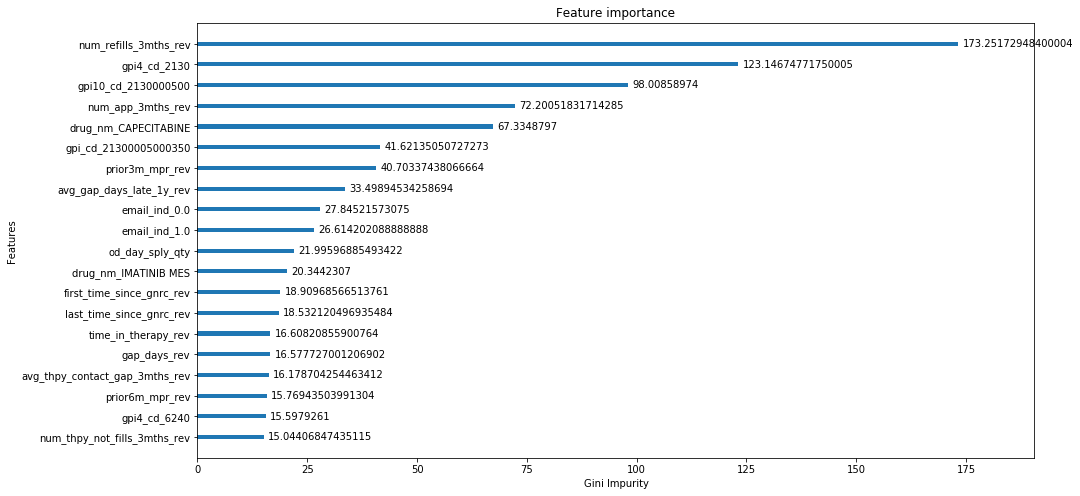

In [212]:
f, ax = plt.subplots(figsize = (15,8))
xgb.plot_importance(xgb3, importance_type = 'gain', ax = ax, grid = False, max_num_features = 20, xlabel = 'Gini Impurity')
plt.show()

#### Deep Learning with Keras

In [141]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [142]:
# one-hot encoder for target column
y_train_nn = to_categorical(y_train)

In [143]:
# Create model
model = Sequential()

# get number of columns in training data
n_col = X_train.shape[1]

# Add layers to model
model.add(Dense(12, activation='relu', input_shape=(n_col,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))

W0815 15:41:08.729409 13936 deprecation_wrapper.py:119] From C:\Users\C092329\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 15:41:08.885410 13936 deprecation_wrapper.py:119] From C:\Users\C092329\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 15:41:08.904410 13936 deprecation_wrapper.py:119] From C:\Users\C092329\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [147]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [148]:
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=3)

#train model
model.fit(X_train, y_train_nn, epochs = 30, validation_split = 0.2, callbacks= [early_stopping_monitor])

W0815 15:42:18.992410 13936 deprecation.py:323] From C:\Users\C092329\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0815 15:42:19.094409 13936 deprecation_wrapper.py:119] From C:\Users\C092329\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 39627 samples, validate on 9907 samples
Epoch 1/30
39627/39627 [==============================] - 3s 64us/step - loss: 0.4166 - acc: 0.8326 - val_loss: 0.3894 - val_acc: 0.8474
Epoch 2/30
39627/39627 [==============================] - 2s 54us/step - loss: 0.3911 - acc: 0.8460 - val_loss: 0.3912 - val_acc: 0.8476
Epoch 3/30
39627/39627 [==============================] - 2s 56us/step - loss: 0.3888 - acc: 0.8469 - val_loss: 0.3871 - val_acc: 0.8488
Epoch 4/30
39627/39627 [==============================] - 2s 52us/step - loss: 0.3870 - acc: 0.8480 - val_loss: 0.3877 - val_acc: 0.8485
Epoch 5/30
39627/39627 [==============================] - 2s 49us/step - loss: 0.3857 - acc: 0.8478 - val_loss: 0.3884 - val_acc: 0.8472
Epoch 6/30
39627/39627 [==============================] - 2s 56us/step - loss: 0.3846 - acc: 0.8485 - val_loss: 0.3868 - val_acc: 0.8470
Epoch 7/30
39627/39627 [==============================] - 2s 52us/step - loss: 0.3832 - acc: 0.8492 - val_loss: 0.3854 - val_acc:

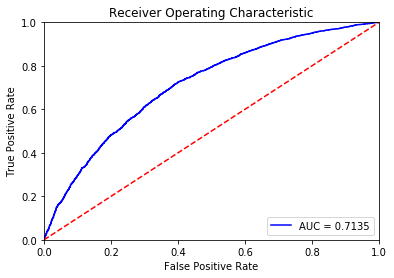

In [149]:
plot_roc(X_test, y_test, model)

#### Ensemble Method

In [80]:
# Instantiate the individual models
clf_knn = KNeighborsClassifier(n_neighbors = 5)
clf_lr = LogisticRegression(class_weight = 'balanced')
clf_dt = DecisionTreeClassifier(min_samples_leaf = 3, min_samples_split = 9, random_state=500)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')), ('lr', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_s...       min_weight_fraction_leaf=0.0, presort=False, random_state=500,
            splitter='best'))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [ ]:
# hard voting
clf_vote = VotingClassifier(
    estimators = [
        ('knn', clf_knn),
        ('lr', clf_lr),
        ('dt', clf_dt)
    ]
)

clf_vote.fit(X_train, y_train)

In [82]:
ypred = clf_vote.predict(X_test)

In [90]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.35      0.30      0.32      1910
           1       0.88      0.90      0.89     10474

   micro avg       0.81      0.81      0.81     12384
   macro avg       0.61      0.60      0.61     12384
weighted avg       0.80      0.81      0.80     12384



In [96]:
### Soft Voting
clf_voting = VotingClassifier(
    estimators = [
        ('knn', clf_knn),
        ('dt', clf_dt),
        ('lr', clf_lr)
    ],
    voting = 'soft'
)

clf_voting.fit(X_train,y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')), ('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=Non...penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [97]:
ypred = clf_voting.predict(X_test)

              precision    recall  f1-score   support

           0       0.37      0.24      0.29      1910
           1       0.87      0.92      0.90     10474

   micro avg       0.82      0.82      0.82     12384
   macro avg       0.62      0.58      0.59     12384
weighted avg       0.79      0.82      0.80     12384



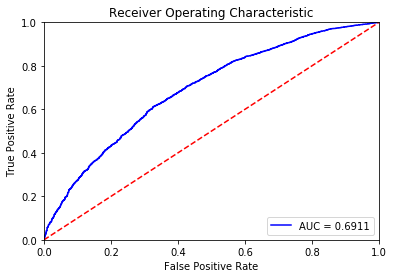

In [101]:
plot_roc(X_test, y_test, algo = clf_voting)

#### Bagging

* `base_estimator`: base estimator
* `oob_score`: Compute the oob score when building tree
* `n_estimators`: number of weak learners in the bagging
* `max_samples`: the number of samples to draw for each estimator
* `max_features`: the number of features to draw for each estimator
* `bootstrap`: sample with replacement

In [103]:
dt = DecisionTreeClassifier(max_depth = 4, max_features = 4)

In [105]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

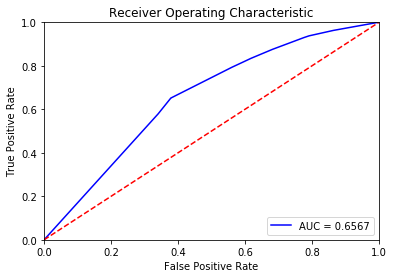

In [106]:
plot_roc(X_test, y_test, algo = dt)

In [109]:
clf_bag = BaggingClassifier(
    base_estimator = dt,
    n_estimators = 100,
    oob_score = True,
    random_state=123
)

In [110]:
clf_bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=None, oob_score=True,
         random_state=123, verbose=0, warm_start=False)

In [116]:
y_pred = clf_bag.predict(X_test)

In [120]:
print('The Out-of-Bag accuracy score is {:.4f} \nThe test accuracy score is {:.4f}'.format(clf_bag.oob_score_, 
                                                                                             accuracy_score(y_test, y_pred)))

The Out-of-Bag accuracy score is 0.8460 
The test accuracy score is 0.8458


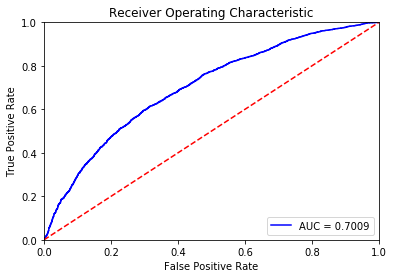

In [112]:
plot_roc(X_test, y_test, algo = clf_bag)

#### AdaBoost

In [130]:
dt = DecisionTreeClassifier(max_depth = 1) # base learner is a decision stump

clf_ada = AdaBoostClassifier(
    base_estimator = dt,
    n_estimators = 100,
    learning_rate = 0.5
)

clf_ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=100, random_state=None)

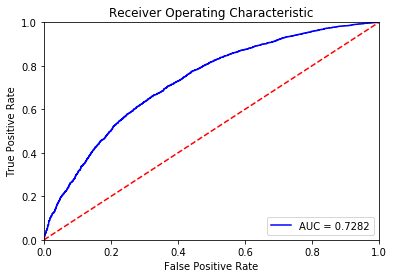

In [131]:
plot_roc(X_test, y_test, clf_ada)

#### Stacked ensemble

**General Steps**:
    1. Prepare the dataset
    2. Build the first-layer estimators
    3. Append the predictions to the dataset
    4. Build the second-layer meta estimator
    5. Use the stacked ensemble for predictions

In [132]:
clf_dt = DecisionTreeClassifier(random_state = 42)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [133]:
clf_knn = KNeighborsClassifier(n_neighbors = 5, algorithm = 'ball_tree')
clf_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [134]:
# Create a Pandas DataFrame with the predictions
pred_df = pd.DataFrame({
    'pred_dt': clf_dt.predict(X_train),
    'pred_knn': clf_knn.predict(X_train)
}, index = X_train.index)

# Concatenate X_train with the predictions DataFrame
X_train_2nd = pd.concat([X_train, pred_df], axis = 1)

# Build the second-layer meta estimator
clf_stack = LogisticRegression(random_state = 42, class_weight = 'balanced')
clf_stack.fit(X_train_2nd, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [135]:
# Create a Pandas DataFrame with the predictions
pred_df = pd.DataFrame({
    'pred_dt': clf_dt.predict(X_test) ,
    'pred_knn': clf_knn.predict(X_test)
}, index=X_test.index)

# Concatenate X_test with the predictions DataFrame
X_test_2nd = pd.concat([X_test, pred_df], axis = 1)

# Obtain the final predictions from the second-layer estimator
pred_stack = clf_stack.predict(X_test_2nd)

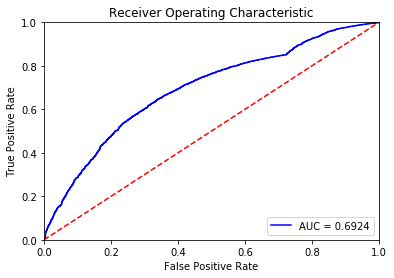

In [136]:
plot_roc(X_test_2nd, y_test, clf_stack)

#### MLXtend Stacking

In [137]:
from mlxtend.classifier import StackingClassifier

In [138]:
# Instantiate the first-layer classifiers
clf_dt = DecisionTreeClassifier(min_samples_leaf = 3, min_samples_split = 9, random_state=500)
clf_knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')

# Instantiate the second-layer meta classifier
clf_meta = DecisionTreeClassifier(random_state=500)

# Build the Stacking classifier
clf_stack = StackingClassifier(
    classifiers=[clf_dt, clf_knn], 
    meta_classifier=clf_meta, 
    use_features_in_secondary = True) # include the original input features

clf_stack.fit(X_train, y_train)

StackingClassifier(average_probas=False,
          classifiers=[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=9,
            min_weight_fraction_leaf=0.0, ...ski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')],
          drop_last_proba=False,
          meta_classifier=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=500,
            splitter='best'),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=True, use_probas=False, verbose=0)

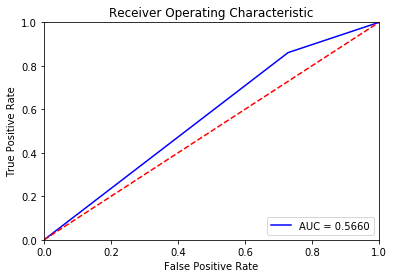

In [139]:
plot_roc(X_test, y_test, clf_stack)